# Finetuning Milestone

Note: This notebook was run on COLAB due to high GPU requirements

In [ ]:
!pip install -qqq "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git" --progress-bar off
from torch import __version__; from packaging.version import Version as V
xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
!pip install -qqq --no-deps {xformers} trl peft accelerate bitsandbytes triton --progress-bar off

import torch
from trl import SFTTrainer
from datasets import load_dataset
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel, is_bfloat16_supported

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## 1. Load model for PEFT

In [ ]:
# Load model
max_seq_length = 2048
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

# Prepare model for PEFT
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth"
)
print(model.print_trainable_parameters())

==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Unsloth 2024.12.2 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


trainable params: 24,313,856 || all params: 3,237,063,680 || trainable%: 0.7511
None


## 2. Prepare data and tokenizer

In [ ]:
from datasets import Dataset

tokenizer = get_chat_template(
    tokenizer,
    chat_template="chatml",
    mapping={"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}
)

def apply_template(examples):
    messages = examples["conversations"]
    text = [tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=False) for message in messages]
    return {"text": text}

dataset = Dataset.from_json("formatted_dataset.json")
dataset = dataset.map(apply_template, batched=True)

Unsloth: Will map <|im_end|> to EOS = <|im_end|>.


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/951 [00:00<?, ? examples/s]

## 3. Training

In [ ]:
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        num_train_epochs=1,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

trainer.train()

Generating train split: 0 examples [00:00, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 500 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 31
 "-____-"     Number of trainable parameters = 24,313,856
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
1,1.866800
2,1.760400
3,1.760900
4,1.888600
5,1.671400
6,1.707400
7,1.800700
8,1.630400
9,1.616400
10,1.514100


TrainOutput(global_step=31, training_loss=1.5075826952534337, metrics={'train_runtime': 1537.5821, 'train_samples_per_second': 0.325, 'train_steps_per_second': 0.02, 'total_flos': 1.7328026161250304e+16, 'train_loss': 1.5075826952534337, 'epoch': 0.992})

## 4. Inference

In [ ]:
# Load model for inference
model = FastLanguageModel.for_inference(model)

messages = [
    {"from": "human", "value": "This is the document context:\nContext 1 Title: ros-navigation/docs.nav2.org\nContext content: \n## Costmap2D `current_` Usage\u00b6\n\nIn costmap2D, `current_` was used in ROS1 to represent whether a costmap layer\nwas still enabled and actively processing data. It would be turned to `false`\nonly under the situation that the expected update rate of a sensor was not\nmet, so it was getting stale or no messages. It acts as a fail-safe for if a\nnavigation sensor stops publishing.\n\nIn galactic, that will remain turn, however it will also add additional\ncapabilities. It is also now set to `false` when a costmap is reset due to\nclearing or other navigation recoveries. That stops the robot from creating a\nplan or control effort until after the costmap has been updated at least once\nafter a reset. This enables us to make sure we cannot ever create a path or\ncontrol with a completely empty costmap, potentially leading to collisions,\ndue to clearing the costmap and then immediately requesting an algorithm to\nrun.\n\n## Standard time units in parameters\u00b6\n\n\nContext 2 Title: ros-navigation/docs.nav2.org\nContext content: \nArchitecturally, costmap filters consists from `CostmapFilter` class which is\na basic class incorporating much common of its inherited filter plugins:\n\n  * `KeepoutFilter`: keep-out/safety zones filter plugin.\n\n  * `SpeedFilter`: slow/speed-restricted areas filter.\n\n  * Preferred lanes in industries. This plugin is covered by `KeepoutFilter` (see discussion in corresponding PR for more details).\n\nEach costmap filter subscribes to filter info topic (publishing by Costmap\nFilter Info Publisher Server) having all necessary information for loaded\ncostmap filter and filter mask topic. `SpeedFilter` additionally publishes\nmaximum speed restricting messages targeted for a Controller to enforce robot\nwon\u2019t exceed given limit.\n\n\nContext 3 Title: ros-navigation/docs.nav2.org\nContext content: \nSeveral example implementations are included in `nav2_waypoint_follower`.\n`WaitAtWaypoint` and `PhotoAtWaypoint` plusings are included in\n`nav2_waypoint_follower` as run-time loadable plugins. `WaitAtWaypoint` simply\nlets robot to pause for a specified amount of time in milliseconds, at\nwaypoint arrivals. While `PhotoAtWaypoint` takes photos at waypoint arrivals\nand saves the taken photos to specified directory, the format for taken photos\nalso can be configured through parameters. All major image formats such as\n`png`, `jpeg`, `jpg` etc. are supported, the default format is `png`.\n\nLoading a plugin of this type is done through\n`nav2_bringup/params/nav2_param.yaml`, by specifying plugin\u2019s name, type and\nit\u2019s used parameters.\n\n\nThis is the user prompt:  What is the role of the `current_` variable in the Costmap2D class in ROS2 and how has its functionality changed in the Galactic release?\n Can you describe the structure and purpose of costmap filters in ROS2's navigation stack?\n How can plugins like `WaitAtWaypoint` and `PhotoAtWaypoint` be utilized in the `nav2_waypoint_follower` in ROS2, and what parameters are essential for their configuration?\n\n\nUsing the given document context pertaining to ROS2, answer the question prompted by the user."},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids=inputs, streamer=text_streamer, max_new_tokens=1000, use_cache=True)

<|im_start|>user
This is the document context:
Context 1 Title: ros-navigation/docs.nav2.org
Context content: 
## Costmap2D `current_` Usage¶

In costmap2D, `current_` was used in ROS1 to represent whether a costmap layer
was still enabled and actively processing data. It would be turned to `false`
only under the situation that the expected update rate of a sensor was not
met, so it was getting stale or no messages. It acts as a fail-safe for if a
navigation sensor stops publishing.

In galactic, that will remain turn, however it will also add additional
capabilities. It is also now set to `false` when a costmap is reset due to
clearing or other navigation recoveries. That stops the robot from creating a
plan or control effort until after the costmap has been updated at least once
after a reset. This enables us to make sure we cannot ever create a path or
control with a completely empty costmap, potentially leading to collisions,
due to clearing the costmap and then immediately request

## 5. Save trained model

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `Colab_Write` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Colab_Write`

In [ ]:
model.save_pretrained_merged("model", tokenizer, save_method="merged_16bit")
model.push_to_hub_merged("Chinnu1103/ROSLlama", tokenizer, save_method="merged_16bit")

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 2.2G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.07 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:01<00:00, 27.83it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model/pytorch_model-00001-of-00002.bin...
Unsloth: Saving model/pytorch_model-00002-of-00002.bin...
Done.


Unsloth: You are pushing to hub, but you passed your HF username = Chinnu1103.
We shall truncate Chinnu1103/ROSLlama to ROSLlama


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 3.99 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 30.82it/s]


Unsloth: Saving tokenizer...

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

 Done.
Unsloth: Saving ROSLlama/pytorch_model-00001-of-00002.bin...
Unsloth: Saving ROSLlama/pytorch_model-00002-of-00002.bin...


README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/Chinnu1103/ROSLlama


In [ ]:
model.save_pretrained_gguf("model", tokenizer, "q8_0")
quant_methods = ["q2_k", "q3_k_m", "q4_k_m", "q5_k_m", "q6_k", "q8_0"]
for quant in quant_methods:
    model.push_to_hub_gguf("Chinnu1103/ROSLlama-GGUF", tokenizer, quant)

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.48 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:01<00:00, 21.61it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model/pytorch_model-00001-of-00002.bin...
Unsloth: Saving model/pytorch_model-00002-of-00002.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q8_0'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at model into q8_0 GGUF format.
The output location will be /content/model/unsloth.Q8_0.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00002.bin

100%|██████████| 28/28 [00:00<00:00, 29.47it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00001-of-00002.bin...
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00002-of-00002.bin...
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q2_k'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at Chinnu1103/ROSLlama-GGUF into f16 GGUF format.
The output location will be /content/Chinnu1103/ROSLlama-GGUF/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: ROSLlama-GGUF
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F

unsloth.Q2_K.gguf:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Saved GGUF to https://huggingface.co/Chinnu1103/ROSLlama-GGUF


No files have been modified since last commit. Skipping to prevent empty commit.


Saved Ollama Modelfile to https://huggingface.co/Chinnu1103/ROSLlama-GGUF
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.53 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 29.11it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00001-of-00002.bin...
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00002-of-00002.bin...
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q3_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at Chinnu1103/ROSLlama-GGUF into f16 GGUF format.
The output location will be /content/Chinnu1103/ROSLlama-GGUF/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: ROSLlama-GGUF
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 -->

unsloth.Q3_K_M.gguf:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved GGUF to https://huggingface.co/Chinnu1103/ROSLlama-GGUF


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Saved Ollama Modelfile to https://huggingface.co/Chinnu1103/ROSLlama-GGUF
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.53 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 30.38it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00001-of-00002.bin...
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00002-of-00002.bin...
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at Chinnu1103/ROSLlama-GGUF into f16 GGUF format.
The output location will be /content/Chinnu1103/ROSLlama-GGUF/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: ROSLlama-GGUF
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 -->

unsloth.Q4_K_M.gguf:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Saved GGUF to https://huggingface.co/Chinnu1103/ROSLlama-GGUF


No files have been modified since last commit. Skipping to prevent empty commit.


Saved Ollama Modelfile to https://huggingface.co/Chinnu1103/ROSLlama-GGUF
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.53 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 29.90it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00001-of-00002.bin...
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00002-of-00002.bin...
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q5_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at Chinnu1103/ROSLlama-GGUF into f16 GGUF format.
The output location will be /content/Chinnu1103/ROSLlama-GGUF/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: ROSLlama-GGUF
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 -->

unsloth.Q5_K_M.gguf:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved GGUF to https://huggingface.co/Chinnu1103/ROSLlama-GGUF


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Saved Ollama Modelfile to https://huggingface.co/Chinnu1103/ROSLlama-GGUF
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.47 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 29.93it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00001-of-00002.bin...
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00002-of-00002.bin...
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q6_k'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at Chinnu1103/ROSLlama-GGUF into f16 GGUF format.
The output location will be /content/Chinnu1103/ROSLlama-GGUF/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: ROSLlama-GGUF
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F

unsloth.Q6_K.gguf:   0%|          | 0.00/2.64G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved GGUF to https://huggingface.co/Chinnu1103/ROSLlama-GGUF


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Saved Ollama Modelfile to https://huggingface.co/Chinnu1103/ROSLlama-GGUF
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.46 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 28/28 [00:00<00:00, 30.00it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00001-of-00002.bin...
Unsloth: Saving Chinnu1103/ROSLlama-GGUF/pytorch_model-00002-of-00002.bin...
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q8_0'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at Chinnu1103/ROSLlama-GGUF into q8_0 GGUF format.
The output location will be /content/Chinnu1103/ROSLlama-GGUF/unsloth.Q8_0.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: ROSLlama-GGUF
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 -->

unsloth.Q8_0.gguf:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved GGUF to https://huggingface.co/Chinnu1103/ROSLlama-GGUF


No files have been modified since last commit. Skipping to prevent empty commit.


Saved Ollama Modelfile to https://huggingface.co/Chinnu1103/ROSLlama-GGUF


## Finetuning Report

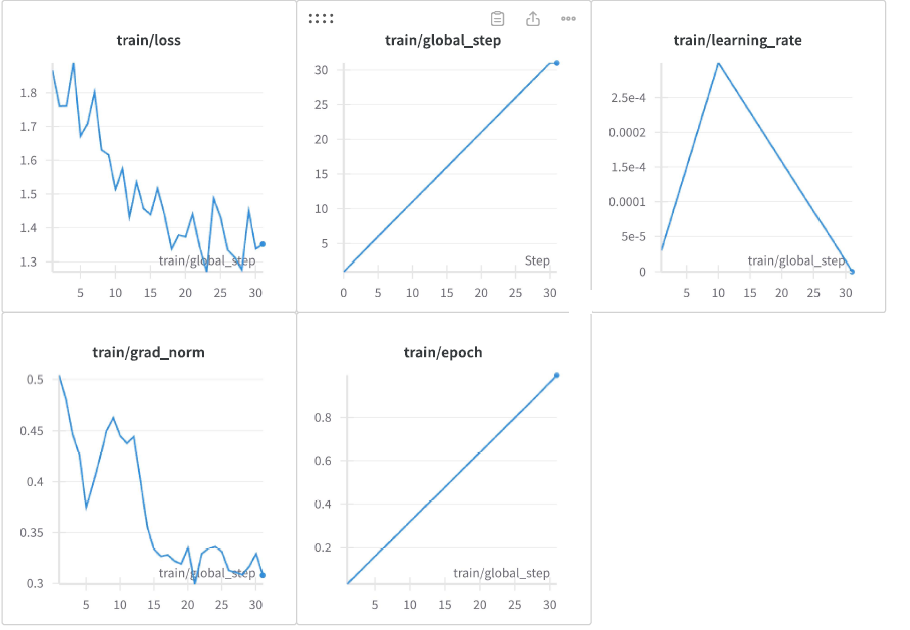

In [1]:
from IPython.display import Image

Image('screenshots/finetuning_report.png')